In [1]:
import pygimli as pg
from pygimli.physics.seismics import solvePressureWave, ricker
import numpy as np
from matplotlib.pyplot import figure
from pygimli.viewer import show
import pygimli.meshtools.polytools as plc
from pygimli.meshtools import createMesh
from pygimli.mplviewer import drawMesh
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
def polyCreateDefaultEdges_(poly, boundaryMarker=1, isClosed=True, **kwargs):
    """INTERNAL"""

    nEdges = poly.nodeCount()-1 + isClosed
    bm = None
    if hasattr(boundaryMarker, '__len__'):
        if len(boundaryMarker) == nEdges:
            bm = boundaryMarker
        else:
            raise Exception("marker length != nEdges",
                            len(boundaryMarker), nEdges)
    else:
        bm = [boundaryMarker] * nEdges

    for i in range(poly.nodeCount() - 1):
        poly.createEdge(poly.node(i), poly.node(i+1), bm[i])
        
    if isClosed:
        poly.createEdge(poly.node(poly.nodeCount()-1),
                        poly.node(0), bm[-1])
        
def createCircle(pos=None, radius=1, segments=12, start=0, end=2.*math.pi, 
                 spike=False, phi0=0, x_shift=0, y_shift=0, **kwargs):

    """
    Create simple circle polygon.

    Parameters
    ----------
    pos : [x, y] [[0.0, 0.0]]
        Center position
    radius : float | [a,b] [1]
        radius or halfaxes of the circle
    segments : int
        Discrete amount of segments for the circle
    start : double [0]
        Starting angle in radians
    end : double [2*pi]
        Ending angle in radians

    **kwargs:

        marker : int [1]
            Marker for the resulting triangle cells after mesh generation
        area : float [0]
            Maximum cell size for resulting triangles after mesh generation
        boundaryMarker : int [1]
            Marker for the resulting boundary edges
        leftDirection : bool [True]
            Rotational direction
        isHole : bool [False]
            The Polygone will become a hole instead of a triangulation
        isClosed : bool [True]
            Add closing edge between last and first node.

    Returns
    -------
    poly : gimliapi:`GIMLI::Mesh`
        The resulting polygon is a gimliapi:`GIMLI::Mesh`.

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> from pygimli.mplviewer import drawMesh
    >>> import pygimli as pg
    >>> import math
    >>> from pygimli.meshtools import polytools as plc
    >>> c0 = plc.createCircle(pos=(-5.0, 0.0), radius=2, segments=6)
    >>> c1 = plc.createCircle(pos=(0.0, 0.0), segments=5, start=0, end=math.pi)
    >>> c2 = plc.createCircle(pos=(5.0, 0.0), segments=3, start=math.pi,
    ...                       end=1.5*math.pi, isClosed=False)
    >>> plc = plc.mergePLC([c0, c1, c2])
    >>>
    >>> fig, ax = plt.subplots()
    >>> drawMesh(ax, plc)
    >>> plt.show()
    """

    if pos is None:
        pos = [0.0, 0.0]

    poly = pg.Mesh(2)

    dPhi = (end - start) / (segments)
    nPhi = segments + 1

    if abs((end % (2. * math.pi) - start)) < 1e-6:
        nPhi = segments

    for i in range(0, nPhi):
        if kwargs.pop('leftDirection', True):
            phi = start + i * dPhi
        else:
            phi = start - i * dPhi

        phi += phi0
        xp = np.cos(phi)
        yp = np.sin(phi)
        poly.createNode([xp, yp])
        
    if spike:
        poly.createNode([xp - 0.1 * math.cos(phi0) + x_shift, yp - 0.1 * math.sin(phi0) + y_shift])
        print(xp,yp)

    if kwargs.pop('isHole', False):
        poly.addHoleMarker([0.0, 0.0])
    else:
        poly.addRegionMarker([0.0, 0.0],
                             marker=kwargs.pop('marker', 1),
                             area=kwargs.pop('area', 0))

    if hasattr(radius, '__len__'):
        poly.scale(radius)
    else:
        poly.scale([radius, radius])

    poly.translate(pos)

    polyCreateDefaultEdges_(poly, **kwargs)
    
    ## need a better way mess with these or wrong kwargs
    ## pg.warnNonEmptyArgs(kwargs)
    
    return poly


In [3]:
c1 = createCircle([0, 0], radius=240, area=200, segments=90, marker=2, \
                  spike=True, phi0 = 0.75*math.pi, x_shift = -.01, y_shift = -.04)
c2 = createCircle([0, 0], radius=190, area=200, segments=90, isHole=1)

plc_obj = plc.mergePLC([c1,c2])
#grid = createMesh(plc_obj, quality=34.75, area=52)
#grid = createMesh(plc_obj, quality=34.82, area=35)
#grid = createMesh(plc_obj, quality=34.85, area=34)
grid = createMesh(plc_obj, quality=34.51, area=30)
print(grid)

-0.656059028991 0.754709580223
Mesh: Nodes: 3349 Cells: 6250 Boundaries: 9599


In [ ]:


fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#drawMesh(ax1, plc_obj)
drawMesh(ax1, grid)
drawMesh(ax2, grid)

screenSize = 110
x_center = -130
y_center = 130
ax2.set_xlim(x_center-screenSize, x_center+screenSize)
ax2.set_ylim(y_center-screenSize, y_center+screenSize)

ax1.set_xlim(-260,260)
ax1.set_ylim(-260,260)

for i,node in enumerate(c2.nodes()):
    
    if 35 - 8 < i < 35 + 8:
        ax1.plot(node.x(),node.y(),'or', ms=5)
        ax2.plot(node.x(),node.y(),'or', ms=10)

        if i == 35:
            ax1.plot(node.x(),node.y(),'ob', ms=5)
            ax2.plot(node.x(),node.y(),'ob', ms=10)
            
            sou_x, sou_y = node.x(), node.y()
            
        if i == 35 - 7:
            sensor1_x, sensor1_y = node.x(), node.y()            
        if i == 33:
            sensor2_x, sensor2_y = node.x(), node.y() 
            
from matplotlib.patches import Ellipse
el = Ellipse((2, -1), 0.5, .5)
anno1 = ax2.annotate('Wall defect', xy=(-160,170), xytext=(-220, 210),
                     arrowprops=dict(arrowstyle="simple",
                     fc=".2", ec="none", patchB=el, 
                     connectionstyle="arc3,rad=0.1"))
anno1.set_fontsize(13)

anno2 = ax2.annotate('Omni-directional\npressure source', xy=(sou_x + 4, sou_y - 4), xytext=(-150, 60),
                     arrowprops=dict(arrowstyle="simple",
                     fc=".2", ec="none", patchB=el, 
                     connectionstyle="arc3,rad=0."))
anno2.set_fontsize(13)

anno3 = ax2.annotate('Pressure \nsensor', xy=(sensor1_x + 4, sensor1_y - 4), xytext=(-90, 110),
                     arrowprops=dict(arrowstyle="simple",
                     fc=".2", ec="none", patchB=el, 
                     connectionstyle="arc3,rad=0."))
anno3.set_fontsize(13)

anno4 = ax2.annotate('         ', xy=(sensor2_x + 4, sensor2_y - 4), xytext=(-90, 115),
                     arrowprops=dict(arrowstyle="simple",
                     fc=".2", ec="none", patchB=el, 
                     connectionstyle="arc3,rad=0."))
anno4.set_fontsize(13)

for ax in [ax1,ax2]:
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')    
    
plt.show()
fig.savefig('mesh.png')

In [32]:
anno1.get_fontsize()

10.0

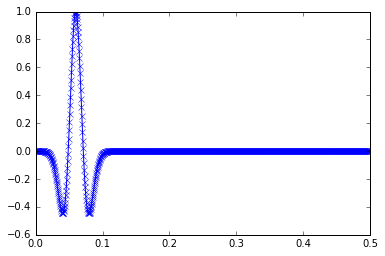

In [7]:
times = pg.RVector(np.linspace(0,.5,1000))
sourcePos = pg.RVector(np.array([sou_x, sou_y, 0.]))
uSource = ricker(times, 20, 0.06)
verbose = False

#fig = figure()
#ax = fig.add_subplot(111)
#pg.mplviewer.drawMesh(ax, grid)

import matplotlib.pyplot as plt
plt.plot(times,uSource,'-x')

In [6]:
data = []
for cell in grid.cells():
    data.append(400.)

velocities = pg.RVector(np.array(data))

In [7]:
verbose = False
u = solvePressureWave(grid, velocities, times, sourcePos, uSource, verbose)

In [8]:
u_np = np.array(u)
u_np = np.clip(u_np, -0.199, 0.199)

[119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133]


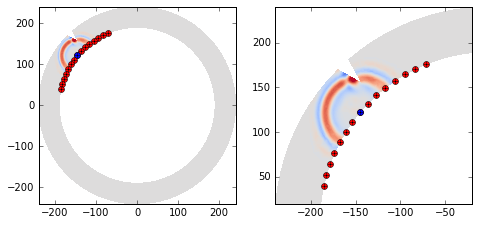

In [9]:
idx = 300
fig = figure(figsize=(12,8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

im1 = pg.mplviewer.drawField(ax1, grid, u_np[idx], \
                            omitLines=True, \
                            cmap='coolwarm', \
                            colorBar=True, \
                            levels=np.linspace(-0.2,0.2, 100))

im2 = pg.mplviewer.drawField(ax2, grid, u_np[idx], \
                            omitLines=True, \
                            cmap='coolwarm', \
                            colorBar=True, \
                            levels=np.linspace(-0.2,0.2, 100))

for i,node in enumerate(c2.nodes()):
    if 35 - 8 < i < 35 + 8:
        ax1.plot(node.x(),node.y(),'or')
        ax2.plot(node.x(),node.y(),'or')
        if i == 35:
            ax1.plot(node.x(),node.y(),'ob')
            ax2.plot(node.x(),node.y(),'ob')
            
screenSize = 110
x_center = -130
y_center = 130
ax2.set_xlim(x_center-screenSize, x_center+screenSize)
ax2.set_ylim(y_center-screenSize, y_center+screenSize)   

grid_x_list, grid_y_list = [], []
for i,node in enumerate(grid.nodes()):
    grid_x_list.append(node.x())
    grid_y_list.append(node.y())


grid_idx_list = []
for i,node in enumerate(c2.nodes()):
    if 35 - 8 < i < 35 + 8:    
        idx = grid.findNearestNode([node.x(), node.y()])
        grid_idx_list.append(idx)
        ax1.plot(grid_x_list[idx], grid_y_list[idx],'k+')
        ax2.plot(grid_x_list[idx], grid_y_list[idx],'k+')

print(grid_idx_list)

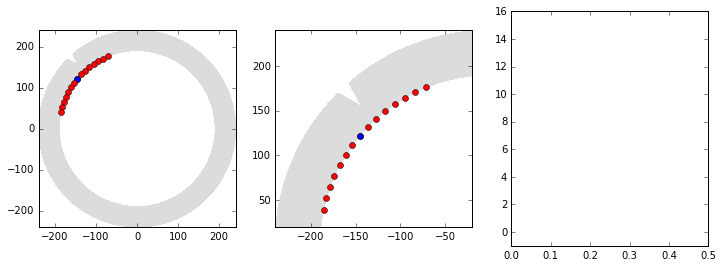

In [10]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


def updatefig(i):
    ax1.clear()
    p = [pg.mplviewer.drawField(ax1, grid, u_np[int(i)], \
                                omitLines=True, cmap='coolwarm', \
                                colorBar=True, levels=np.linspace(-0.2,0.2, 100))]
    ax2.clear()
    p = [pg.mplviewer.drawField(ax2, grid, u_np[int(i)], \
                                omitLines=True, cmap='coolwarm', \
                                colorBar=True, levels=np.linspace(-0.2,0.2, 100))]
    
    screenSize = 110
    x_center = -130
    y_center = 130
    ax2.set_xlim(x_center-screenSize, x_center+screenSize)
    ax2.set_ylim(y_center-screenSize, y_center+screenSize) 
    
    for k,node in enumerate(c2.nodes()):
        if 35 - 8 < k < 35 + 8:
            ax2.plot(node.x(),node.y(),'or')
            ax1.plot(node.x(),node.y(),'or')
            if k == 35:
                ax1.plot(node.x(),node.y(),'ob')
                ax2.plot(node.x(),node.y(),'ob')
    #ax.set_title(str(int(i)))

    #Update traces
    ax3.clear()
    max_time_idx = int(i)
    for j, grid_idx in enumerate(grid_idx_list):
         ax3.plot(np.array(times)[0:max_time_idx], \
                  3*u_np[0:max_time_idx, grid_idx_list[j]] + j, 'k')

    ax3.set_xlim([0, np.max(np.array(times))])
    ax3.set_ylim([-1, len(grid_idx_list)+1 ])
    ax3.set_aspect(.035)
    
    plt.draw()
    

anim = animation.FuncAnimation(fig, updatefig, np.linspace(0,999,100))
anim.save('out_2.mp4', fps=20, dpi=150)

In [11]:
anim.save('out_2.gif', writer='imagemagick', fps=20)